In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.polynomial.chebyshev import Chebyshev

from intsam import RankApprox2dim, cheby_root_grid

---

In [21]:
cheb_f = Chebyshev([1, 2, 3])

In [22]:
cheb_f(4)

102.0

In [31]:
def integrate_indef_cheb(cheb_f:Chebyshev, x_i=None):
    n = cheb_f.coef.size
    
    coef_cheby = cheb_f.coef[1:]
    c0 = cheb_f.coef[0]
    coef = 1/(2*(np.arange(n)+1))
    w1 = np.concatenate([[0], coef_cheby ])
    w2 = np.concatenate([coef_cheby[1:], [0,0]])
    cheby_coef = np.concatenate([[0], coef*(w1-w2)])
    cheby_coef[1] += c0
    
    cheb_f_int =Chebyshev(cheby_coef)
    if x_i is not None:
        cheby_coef[0] -= cheb_f_int(x_i)
    return Chebyshev(cheby_coef)

def integrate_def_cheb(cheb_f:Chebyshev, domain):
    a, b = domain
    cheb_f_inf = integrate_indef_cheb(cheb_f)
    return cheb_f_inf(b)- cheb_f_inf(a)
    
    

In [32]:
cheb_f_int = integrate_indef_cheb(cheb_f, x_i = 5)

In [33]:
cheb_f_int.coef

array([-264.5,   -0.5,    0.5,    0.5])

In [34]:
cheb_f.coef

array([1., 2., 3.])

2080.0


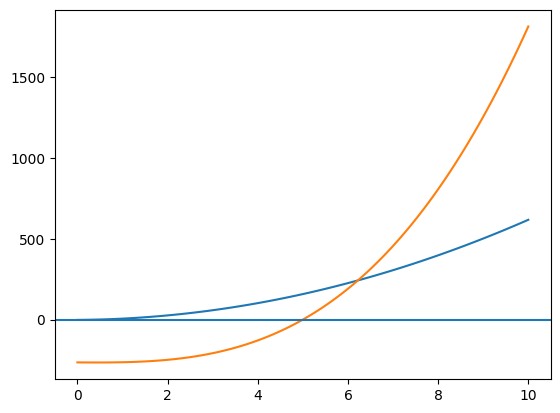

In [36]:
x = np.linspace(0, 10, 100)
y = cheb_f(x)
plt.plot(x, y)
plt.plot(x, cheb_f_int(x))
plt.axhline(0)
print(integrate_def_cheb(cheb_f, [0, 10]))

In [22]:
np.concatenate([cheb_f_4.coef[1:], [0,0]])

array([2., 3., 4., 0., 0.])

In [20]:
1/(np.arange(4)+1)

array([1.        , 0.5       , 0.33333333, 0.25      ])

In [21]:
type(0.1)

float

In [2]:
def test_function(x,y):
    #return 1/(1+100*(1/2 -(x**2+y**2))**2) # a
    #return 1/(1+100*(x**2+y**2)**2) # b
    return 1/(1+1000*(((x**2-1/4)**2) *((y**2-1/4)**2))) # c
    #return np.cos(10*(x**2 +y)) + np.sin(10*(x+y**2)) # d
    #return np.tanh(10*x)*np.tanh(10*y)/np.tanh(10)**2 + np.cos(5*x) # f
    

In [3]:
xdim = (-1, 1)
ydim = (-1, 1)
domain = [xdim[0], ydim[0], xdim[1], ydim[1]]
tol_err = 3E-15

In [4]:
X, Y = np.meshgrid(np.linspace(*xdim , 500), np.linspace(*ydim , 500))

In [5]:
f_approx= RankApprox2dim.from_function_approx(
    test_function, domain, tol_err = 5E-15, initial_step=1, max_step =6,
    include_boundary=False,
    hold_pivot = True)
err = f_approx.add_info["err"]
print(f"Error: {err}, Rank: {f_approx.rank}")

c:\Users\qwqwh\Documents\GitHub\UILC\test\inverse_transform_sampling\intsam.py:300: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fx_v = np.vstack(f(x) for f in self._fx_list)
c:\Users\qwqwh\Documents\GitHub\UILC\test\inverse_transform_sampling\intsam.py:301: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fy_v = np.vstack(f(y) for f in self._fy_list)


Error: 4.9960036108132044e-15, Rank: 40


In [6]:
Z2 = f_approx(X,Y)

In [7]:
ma = Z2.max()
mi = Z2.min()
level_n = 8
level = np.linspace(mi, ma , level_n, endpoint=True)

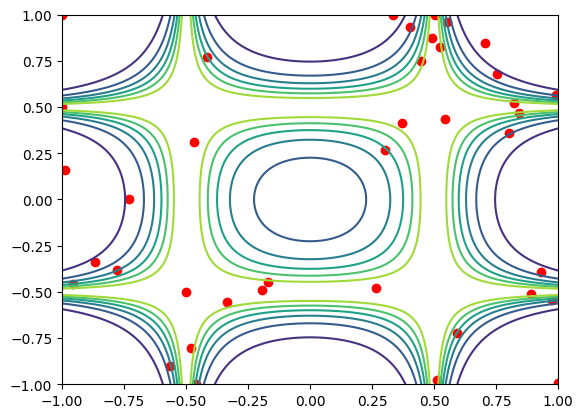

In [8]:
plt.contour(X,Y,Z2, level)
x, y = f_approx.add_info["pivots"].T
plt.scatter(x, y, c="r")

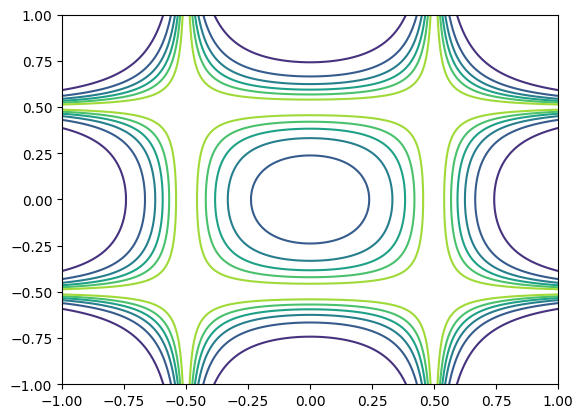

In [9]:
Z = test_function(X,Y)
plt.contour(X,Y,Z)
#plt.scatter(x, y, c="r")

4.90694503230138e-06


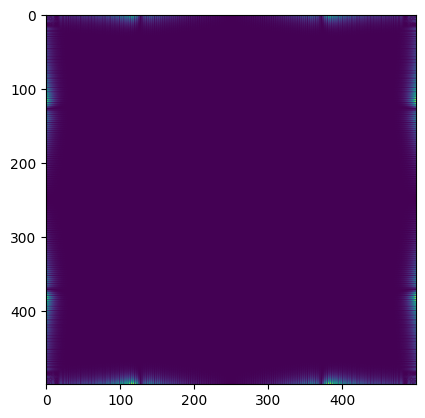

In [10]:
plt.imshow(np.sqrt((Z-Z2)**2))
print(np.sqrt((Z-Z2)**2).max())

In [11]:
np.sqrt((Z-Z2)**2).max()

0.12037703482136308

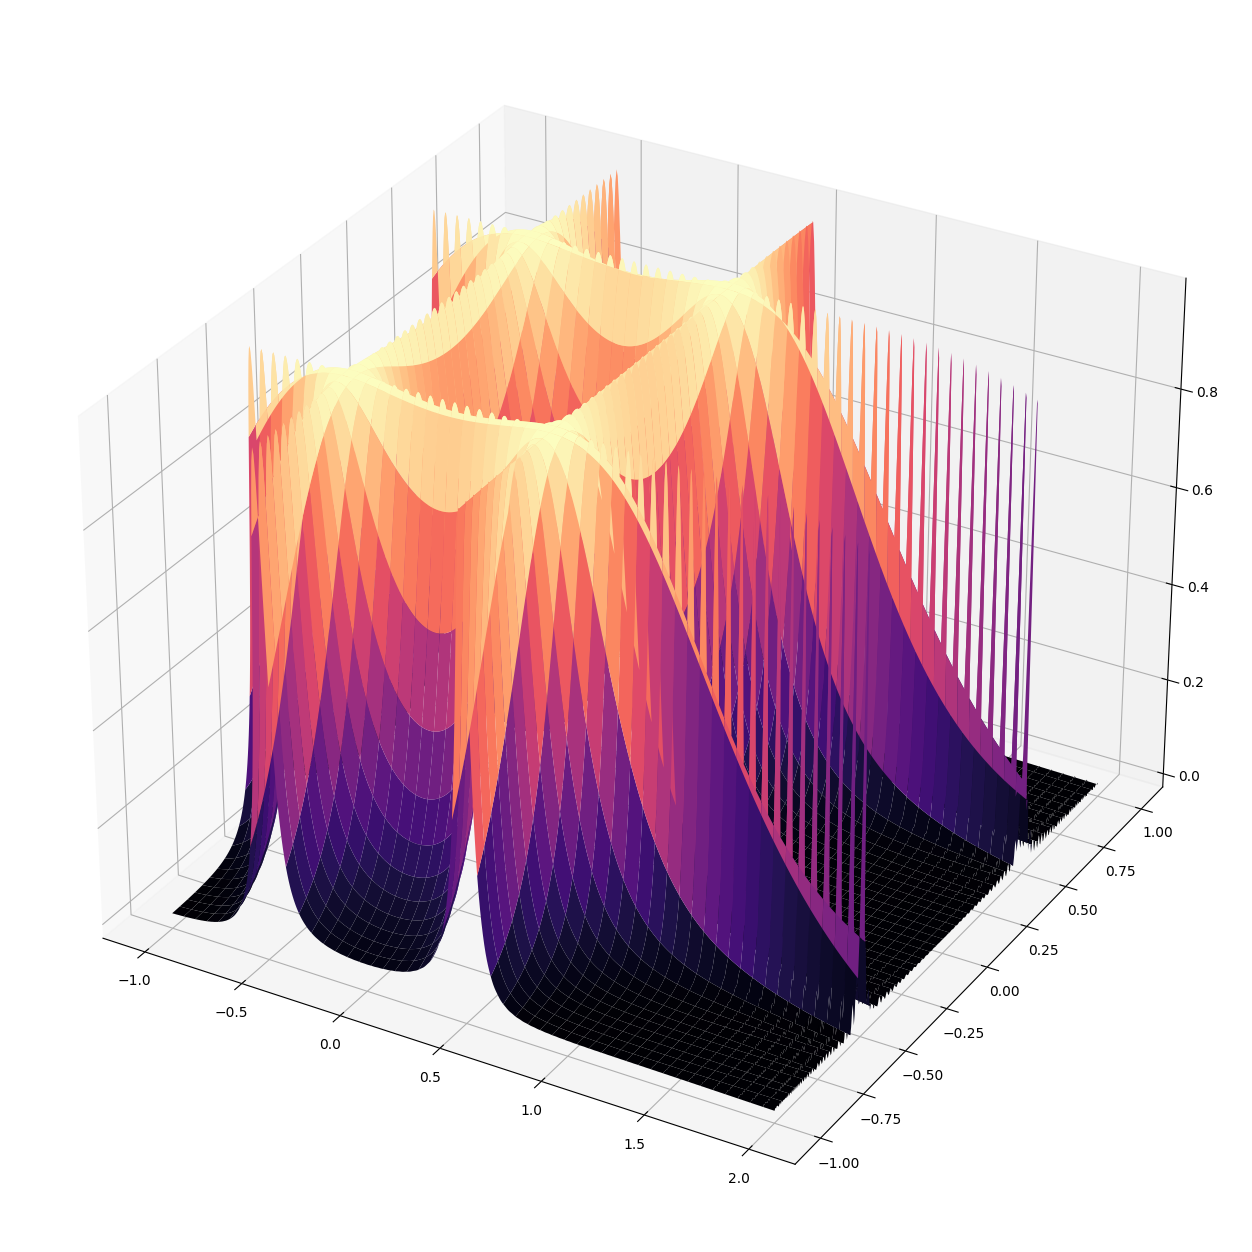

In [12]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y , Z2, cmap="magma")
plt.show()

In [ ]:
# Fixed Chebyshev Degree
def from_function_approx(cls, 
                             f:Callable, 
                             domain:Tuple[Number, Number, Number, Number], 
                             tol_err = 5E-15,
                             initial_step=0,
                             max_step = 6,
                             include_boundary= False,
                             hold_pivot = False,
                             show_process=False):
        if initial_step <0:
            initial_step = 0
        if max_step < initial_step:
            raise ValueError(f"max_step < initial_step: {max_step} < {initial_step}, impossible.")
        
        x_i, x_f =domain[0], domain[2]
        y_i, y_f = domain[1], domain[3]
        
        err = 1.0
        for j in range(initial_step, max_step):
            n, max_step_stage_1 = Cheby_stage_1_params(j)

            cheby_deg= (n-1) if not include_boundary else n+1

            arr_x = cheby_root_grid(x_i, x_f, n)
            arr_y = cheby_root_grid(y_i, y_f, n)
            if include_boundary:
                arr_x = np.insert(arr_x, -1, [x_i, x_f])
                arr_y = np.insert(arr_y, -1, [y_i, y_f])
            arr_x.sort()
            arr_y.sort()

            p_x, p_y = np.meshgrid(arr_x, arr_y)
            _, c_l = p_x.shape

            e_k_approx = cls(lambda x: x, lambda y: y, 0)
            f_k = cls(lambda x: x, lambda y: y, 0)
            def e_k(x, y):
                return f(x, y) + e_k_approx(x, y)
            err = 1.0
            pivots = []
            
            for k in range(0, max_step_stage_1):
                e_k_val = e_k(p_x, p_y)
                err = np.abs(e_k_val).max() 
                if show_process:
                    print(f"Step: {j}, Rank:{f_k.rank}, Err:{err}")
                if err < tol_err: 
                    break
                max_index = np.argmax(e_k_val)
                r = int(max_index/c_l)
                c = max_index%c_l
                x_k, y_k = p_x[r, c], p_y[r, c]
                pivots.append([x_k, y_k])

                u_k, v_k = get_xy_decompose(e_k, (x_k, y_k ), domain, cheby_deg)
                d_k  = 1/ e_k(x_k, y_k)

                e_k_approx.rank_up(u_k, v_k, -d_k)
                f_k.rank_up(       u_k, v_k, d_k)
            
            if err < tol_err: 
                    break
        pivots = np.array(pivots)
        d_values = f(*pivots.T) 
        # do iteration for each row and column line and get 1 dim Chebshev approx
        f_k.add_infos(err = err, pivots = np.array(pivots)) if hold_pivot else f_k.add_infos(err = err)
        return f_k